In [1]:
import os
import sys
import scipy.io
import scipy.misc
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\genge\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# A5サイズ(300dpi)
# IMAGE_HEIGHT = 2480
# IMAGE_WIDTH = 1748

IMAGE_HEIGHT = 1108
IMAGE_WIDTH = 1478
IMAGE_CHANNEL = 3

# imagenetの訓練データの平均画素値
IMAGENET_MEAN = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [3]:
# vgg-19の各層の重みとバイアスを取得
def get_vgg_weight_bias(vgg_layers, n):
    weights_bias = vgg_layers[0][n][0][0][2]
    weights = weights_bias[0][0]
    bias = weights_bias[0][1]
    #layer_name = vgg_layers[0][n][0][0][0][0]
    
    W = tf.constant(weights)
    b = tf.constant(np.reshape(bias, (bias.size)))
    return W, b

In [4]:
# 畳み込み層
def conv2d(x, Wb=None, stride=1, relu=True):
    net = tf.nn.conv2d(x,
                       filter=Wb[0],
                       strides=[1, stride, stride, 1],
                       padding='SAME') + Wb[1]
    if relu:
        return tf.nn.relu(net)
    return net

In [5]:
# プーリング層(アベレージ)
def avg_pool(x, ksize=2, stride=2):
    net = tf.nn.avg_pool(x,
                         ksize=[1, ksize, ksize, 1],
                         strides=[1, stride, stride, 1],
                         padding='SAME')
    return net

In [6]:
def model():
    vgg = scipy.io.loadmat("../models/imagenet-vgg-verydeep-19.mat") # vggの読み込み
    vgg_layers = vgg['layers']
    
    net = {}
    net['input'] = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)).astype('float32'))
    net['conv1_1'] = conv2d(net['input'], get_vgg_weight_bias(vgg_layers, 0))
    net['conv1_2'] = conv2d(net['conv1_1'], get_vgg_weight_bias(vgg_layers, 2))
    net['avg-pool1'] = avg_pool(net['conv1_2'])
    net['conv2_1'] = conv2d(net['avg-pool1'], get_vgg_weight_bias(vgg_layers, 5))
    net['conv2_2'] = conv2d(net['conv2_1'], get_vgg_weight_bias(vgg_layers, 7))
    net['avg-pool2'] = avg_pool(net['conv2_2'])
    net['conv3_1'] = conv2d(net['avg-pool2'], get_vgg_weight_bias(vgg_layers, 10))
    net['conv3_2'] = conv2d(net['conv3_1'], get_vgg_weight_bias(vgg_layers, 12))
    net['conv3_3'] = conv2d(net['conv3_2'], get_vgg_weight_bias(vgg_layers, 14))
    net['conv3_4'] = conv2d(net['conv3_3'], get_vgg_weight_bias(vgg_layers, 16))
    net['avg-pool3'] = avg_pool(net['conv3_4'])
    net['conv4_1'] = conv2d(net['avg-pool3'], get_vgg_weight_bias(vgg_layers, 19))
    net['conv4_2'] = conv2d(net['conv4_1'], get_vgg_weight_bias(vgg_layers, 21))
    net['conv4_3'] = conv2d(net['conv4_2'], get_vgg_weight_bias(vgg_layers, 23))
    net['conv4_4'] = conv2d(net['conv4_3'], get_vgg_weight_bias(vgg_layers, 25))
    net['avg-pool4'] = avg_pool(net['conv4_4'])
    net['conv5_1'] = conv2d(net['avg-pool4'], get_vgg_weight_bias(vgg_layers, 28))
    net['conv5_2'] = conv2d(net['conv5_1'], get_vgg_weight_bias(vgg_layers, 30))
    net['conv5_3'] = conv2d(net['conv5_2'], get_vgg_weight_bias(vgg_layers, 32))
    net['conv5_4'] = conv2d(net['conv5_3'], get_vgg_weight_bias(vgg_layers, 34))
    net['avg-pool5'] = avg_pool(net['conv5_4'])
    return net

コンテンツ画像のコスト関数
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

In [7]:
# コンテンツ画像と生成画像の誤差
def compute_content_cost(a_C, a_G):
    
    # 隠れ層の生成画像の各次元を行ベクトルで取得
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # 列ベクトルに変換
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    # コストの計算
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_C_unrolled - a_G_unrolled), 2))
    
    return J_content

スタイル画像のコスト関数
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2 $$

In [8]:
# グラム行列の生成
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [9]:
# 各層のスタイル画像のコスト関数
def compute_layer_style_cost(a_S, a_G):
    
    # 隠れ層の生成画像の各次元を行ベクトルで取得
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # 各画像を(n_C, n_H*n_W)にリシェイプ
    a_S = tf.reshape(tf.transpose(a_S, [0,3,1,2]), [n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G, [0,3,1,2]), [n_C, n_H*n_W])
    
    # 各画像のグラム行列を計算
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # コストを計算
    J_style_layer = tf.reduce_sum(tf.squared_difference(GS, GG) / (4 * (n_C**2) * (n_H*n_W)**2))
    
    return J_style_layer

スタイル画像のコスト関数の結合
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [10]:
# スタイル画像と生成画像で誤差をとる層(任意)
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)
]

In [11]:
# スタイル画像と生成画像の誤差
def compute_style_cost(model, STYLE_LAYERS):
    
    # スタイルコストの初期化
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        # 出力先の指定
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        
        # 現在の層のスタイルコストを計算
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        # coeff:係数λを用いて，全体のスタイルコストを計算
        J_style += coeff * J_style_layer
    return J_style

トータルコスト関数
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [12]:
# トータルコスト関数
def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J

In [13]:
# 画像の読み込み
def reshape_and_normalize_image(image):
    
    # [width, height, channel]を[1, width, height, channel]にリシェイプ
    image = np.reshape(image, ((1,) + image.shape))
    
    # imagenet-vgg-verydeep-19はimagenetを訓練データにしており，
    # 平均値をゼロにするため，imagenetの平均画素値である[123.68, 116.779, 103.939]
    # を引く必要がある(前処理)
    image = image - IMAGENET_MEAN
    
    return image

In [14]:
# 画像の保存
def save_image(path, image):
    # 前処理で正規化したものを元に戻す
    image = image + IMAGENET_MEANS
    
    # 範囲外の値ならmin/Maxにクリッピング
    np.clip(image[0], 0, 255).astype('uint8')
    
    # 保存
    scipy.misc.imsave(path, image)

In [15]:
# ホワイトノイズの生成
def generate_noise_image(content_image, noise_ratio=0.7):
    
    # ランダムなノイズ画像を生成
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)).astype('float32')
    
    # コンテンツ画像とホワイトノイズ画像を合成した画像を生成
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

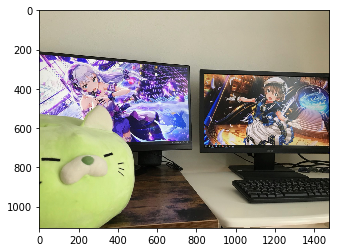

C:\Users\genge\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


In [16]:
content_image = Image.open("../images/zunda.JPG")
plt.imshow(content_image)
plt.show()

content_image = scipy.misc.imread("../images/zunda.JPG")
content_image = reshape_and_normalize_image(content_image)

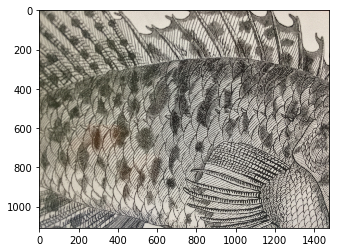

C:\Users\genge\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
C:\Users\genge\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [17]:
style_image = Image.open("../images/IMG_9694.JPG")
# スタイル画像をコンテンツ画像のサイズにリサイズ
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(style_image)
plt.show()

style_image = scipy.misc.imread("../images/IMG_9694.JPG")
# スタイル画像をコンテンツ画像のサイズにリサイズ
style_image = scipy.misc.imresize(style_image, (IMAGE_HEIGHT, IMAGE_WIDTH))
style_image = reshape_and_normalize_image(style_image)

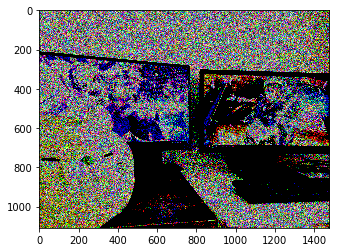

In [18]:
# ホワイトノイズ画像の生成
generated_image = generate_noise_image(content_image)
plt.imshow(np.clip(generated_image[0], 0, 255))

In [19]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [20]:
# 初期化
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [21]:
# vgg-19モデルのロード
net = model()

In [22]:
# vggのinput層にコンテンツ画像を入れる
sess.run(net['input'].assign(content_image))

# 誤差をとる層の選択
out = net['conv4_2']
a_C = sess.run(out)
a_G = out

# コンテンツコストの計算
J_content = compute_content_cost(a_C, a_G)

In [23]:
# vggのinput層にスタイル画像を入れる
sess.run(net['input'].assign(style_image))

# スタイルコストの計算
J_style = compute_style_cost(net, STYLE_LAYERS)